In [ ]:
# title:   coding example - example pipeline for data cleaning, modeling
# author:  peter scarbrough
# date:    26 Jan 2020
# purpose: showcase how to automate aspects of data cleaning, modeling in python

In [1]:
# 1. import required packages
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 2. define global variables
FILENAME   = "housing"
URL        = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/"
LOCAL_PATH = "datasets/"

In [3]:
# 3. download data, load data

def download_housing_data(url=URL, local_path=LOCAL_PATH, filename=FILENAME):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    urllib.request.urlretrieve(url + filename + ".tgz", local_path + filename + ".tgz")
    tgzfile = tarfile.open(local_path + filename + ".tgz")
    tgzfile.extractall(path=local_path)
    tgzfile.close()
    
def load_housing_data(local_path=LOCAL_PATH, filename=FILENAME):
    return(pd.read_csv(local_path+filename+".csv"))

download_housing_data()
data = load_housing_data()        

In [4]:
# 4. exploratory data analysis

# custom print function
def printn(*args):
    print(*args, sep="\n", end="\n\n")
    return(None)

# info on data types
printn("Features/Types:", 
        data.info())

# basic summary measures of numerical variables
printn("Statistical Summaries:", 
        data.describe())


# table of category variable -- note low cts of island category
printn("Category Cts in 'ocean_proximity':", \
        data["ocean_proximity"].value_counts())

# missingness
printn("Missingness Cts:",
        data.apply(lambda x: x.isnull().sum()))

# correlations
print("Linear correlation matrix:")
data.corr().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
Features/Types:
None

Statistical Summaries:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.00,-0.92,-0.11,0.04,0.07,0.10,0.06,-0.02,-0.05
latitude,-0.92,1.00,0.01,-0.04,-0.07,-0.11,-0.07,-0.08,-0.14
housing_median_age,-0.11,0.01,1.00,-0.36,-0.32,-0.30,-0.30,-0.12,0.11
total_rooms,0.04,-0.04,-0.36,1.00,0.93,0.86,0.92,0.20,0.13
total_bedrooms,0.07,-0.07,-0.32,0.93,1.00,0.88,0.98,-0.01,0.05
population,0.10,-0.11,-0.30,0.86,0.88,1.00,0.91,0.00,-0.02
households,0.06,-0.07,-0.30,0.92,0.98,0.91,1.00,0.01,0.07
median_income,-0.02,-0.08,-0.12,0.20,-0.01,0.00,0.01,1.00,0.69
median_house_value,-0.05,-0.14,0.11,0.13,0.05,-0.02,0.07,0.69,1.00


### Notes:  

* low counts in ocean_proximity.island category -- recommend removal
* low counts in bedrooms category -- recommend explore to find imputation strategy

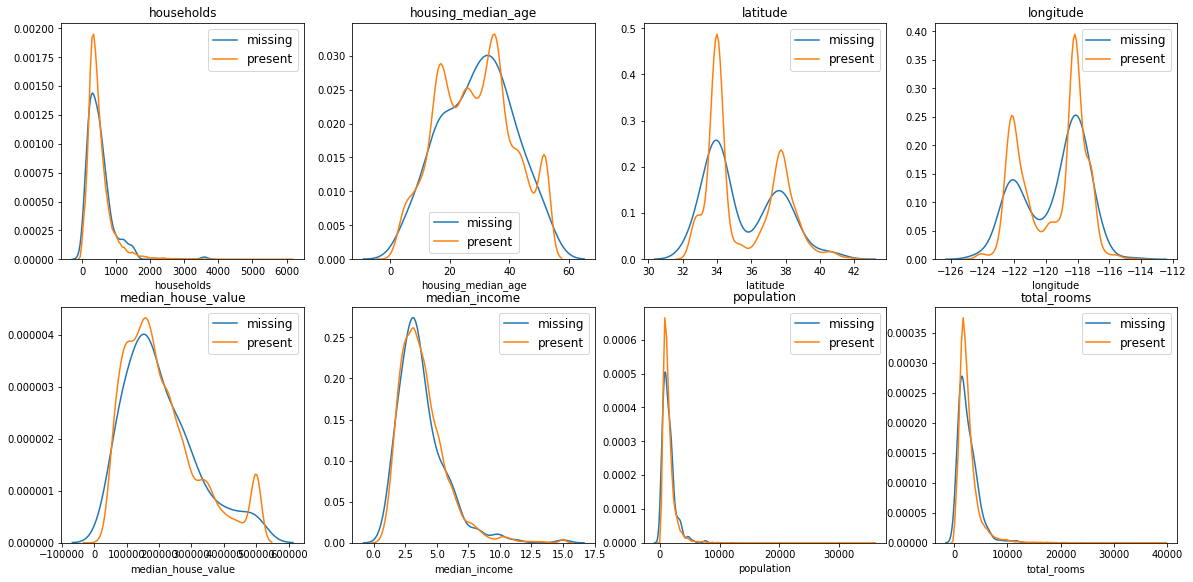

In [5]:
# explore total bedrooms 

# for jupyter notebook plotting
%matplotlib inline

# get numeric and categorical columns
num_cols = data.select_dtypes([np.number]).columns
cat_cols = data.columns.difference(num_cols)

# define function to print by missingness
def plot_miss_density(data, miss_col, num_cols, nrow, ncol):
    fig = plt.figure(figsize=(20,20))
    valid_col = num_cols.difference(np.array([miss_col]))
    for i, col in enumerate(valid_col):
        if col == miss_col:
            continue
        axis = fig.add_subplot(nrow,ncol,i+1)
        sns.distplot(data[data[miss_col].isnull()][col], hist=False, label="missing")
        sns.distplot(data[data[miss_col].notnull()][col], hist=False, label="present")
        axis.set_title(col)
        plt.legend(prop={"size":12})
    plt.show()

# make plots
plot_miss_density(data, "total_bedrooms", num_cols, 4, 4)

### Notes:  

Distribution for numeric variables appears to be very similar between missing and non-missing cases of `total_bedrooms`. Therefore, recommend median imputation strategy to cope with missingness on this variable.

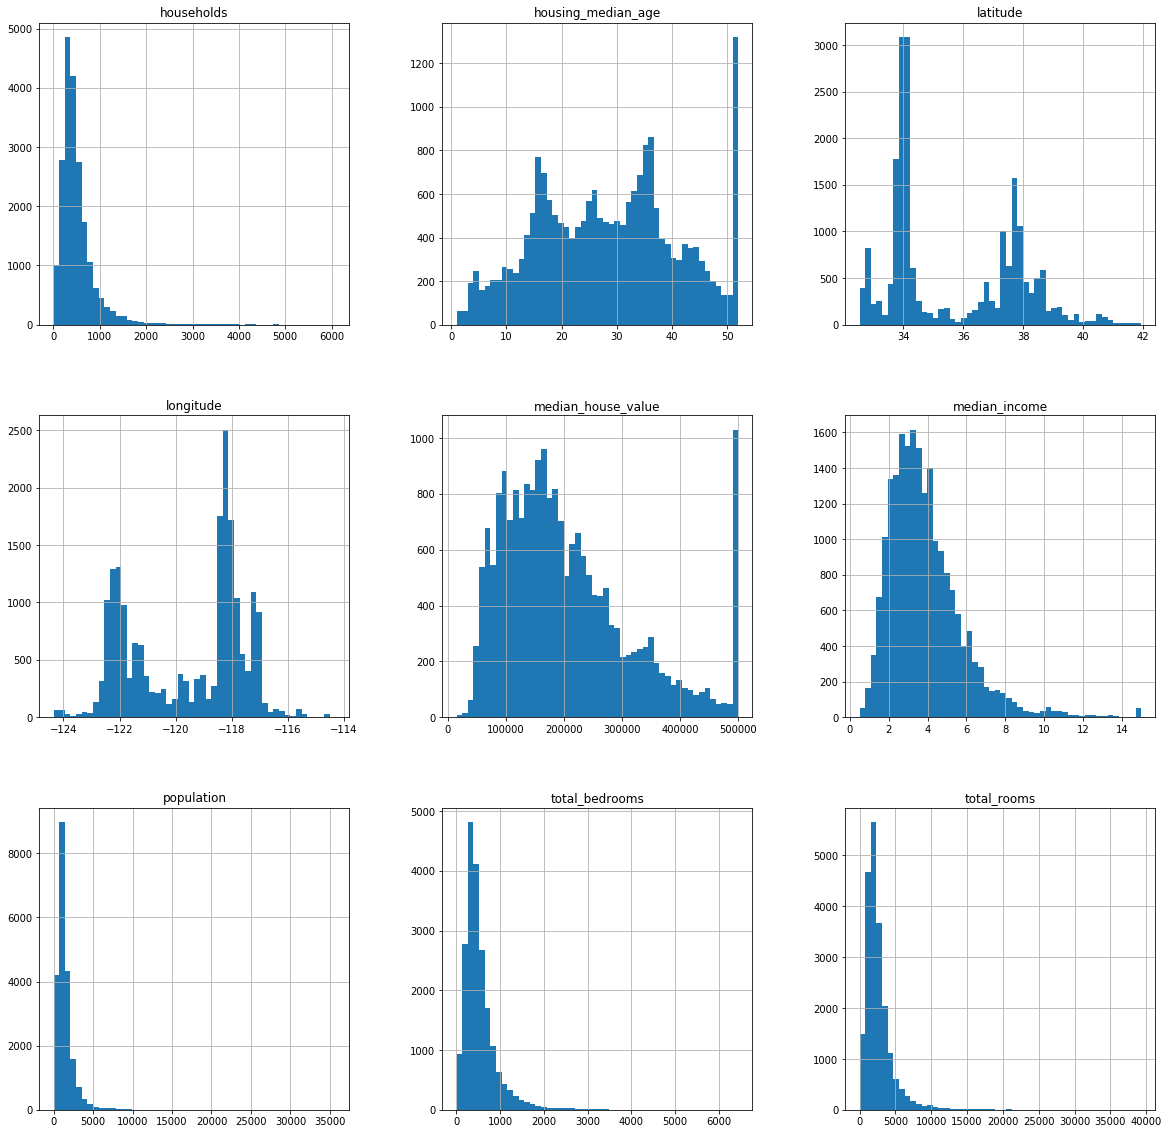

In [6]:
# examine total data histograms

data.hist(bins=50, figsize=(20,20))
plt.show()

### Notes:  

* several variables appear to be right skewed -- recommend log transform on these variables  
* `housing_median_age` and `median_house_value` appear to have capped values in their distribution -- recommend removal  
* `latitude` and `longitude` -- may require clustering to handle info -- inspect further

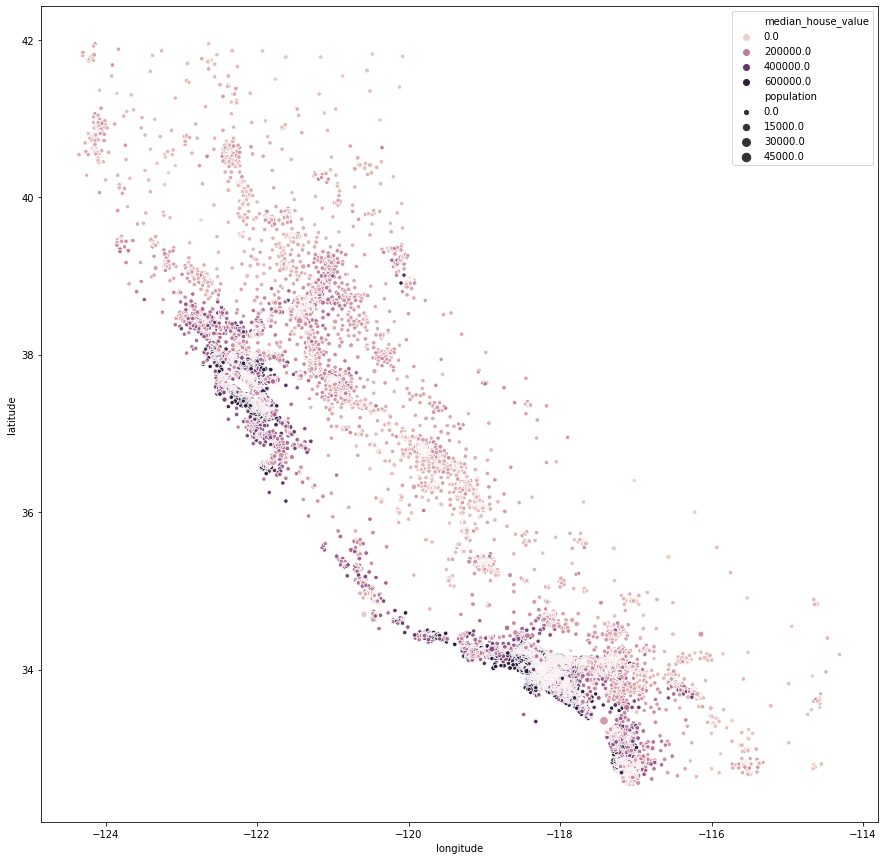

In [7]:
# inspect longitude and latitude

plt.figure(figsize=(15,15))
sns.scatterplot(x="longitude",
                y="latitude",
                hue="median_house_value",
                size="population",
                data=data)
plt.show()

### Notes:  

Appears to be clustering of `median_house_value` based on population and geography. Suggets clustering may be a good strategy for modeling some of this variation in certain data models. However, since I will be using a random forest model later (which will naturally incorporate interaction between latitude/longitude) this is probably not necessary to do in this exercise.

# Steps in Data Pipeline

### Data cleaning, feature engineering

* Drop categories with low counts
* Drop cases with capped measures in 'housing_median_age' and 'median_house_value'
* Test/training data split  

### Transformation - Categorical

* Binary encode categorical data  

### Transformation - Numeric  

* Drop capped high values from indicated variables  
* Log transform indicated variables  
* Scale (mean = 0, var = 1)

### Modeling - Hyperparameter selection (training d*ata)

* Test ridge regression and lasso models with appropriate hyperparameter gridsearch
* Using 10-fold cross-validation

### Modeling - Testing

* Use training data to build testing model  
* Use testing model on test data to estimate model performance  
* Transform full dataset and model with selected hyperparameters to build final model   
* Store final model  

In [8]:
# 6. Data cleaning, feature engineering

# drop categories with low counts (arbitrary: < 50 ct)
def drop_low_ct_rows(data, cat_col, ct=50):
    t   = data[cat_col].value_counts() < 50
    t_i = t.index[t == True]
    for i in t_i:
        data = data[data[cat_col] != i]
    return(data)

data_mod = drop_low_ct_rows(data, "ocean_proximity").copy()

In [9]:
# 7. log transform indicated columns

log_cols = np.array(["households",
                     "population",
                     "total_bedrooms",
                     "total_rooms"])

data_mod[log_cols] = np.log(data_mod[log_cols]+1e-07).copy()

In [10]:
# 8. remove repeated/capped measures from data
# housing_median_age == 52.0 -- remove
# median_house_value == 500001.0 -- remove

data_mod = data_mod.query('housing_median_age != 52.0 & median_house_value != 500001.0')

In [11]:
# 9. partition data into predictor (X) and response (y)
#    keeping track of num and cat columns as well

y_name    = "median_house_value"
X_cols    = data_mod.columns.difference(np.array([y_name]))
X         = data_mod[X_cols]
y         = data_mod[y_name]
X_num_col = X.select_dtypes([np.number]).columns
X_cat_col = X.columns.difference(X_num_col)

In [12]:
# 10. train/test split (80/20)
# TO DO - keep track of training/test indices to prevent bad sampling on any data updates

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

# copying subsets to avoid 'SettingWithCopyWarning'
# note: could just disable warning to avoid if performance ever became an issue
#       it's a good idea to keep warning around as long as that's not the case though

X_train = X_train.copy()
X_test  = X_test.copy()
y_train = y_train.copy()
y_test  = y_test.copy()

# get lists of categorical and numeric column names
X_cat_col = X_train.select_dtypes("object").columns
X_num_col = X_train.columns.difference(X_cat_col)

In [13]:
# 11. Build data transformation pipeline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names
    def fit(self, X, y=None):
        return(self)
    def transform(self, X):
        return(X[self.col_names].values)
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)
    
# setup transformation pipeline

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(X_num_col)),
    ("imputer",  SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(X_cat_col)),
    ("label_binarizer", MyLabelBinarizer())
])

xform_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [14]:
# 12. build modeling pipeline to tune hyperparameters
#     note: using 5-fold cv with mse selection criteria (default)

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# modeling pipeline
# Ridge hyperparameters: alpha
# RandomForestRegressor: max_features, bootstrap (T/F, sample w/replacement), n_estimators
model_pipeline = Pipeline([
    ("xform_pipeline", xform_pipeline),
    ("regressor", RandomForestRegressor())
])

hyperparameter_space = [
    {"regressor": [Ridge()],
     "regressor__alpha": np.logspace(-3,-3,10)},
    {"regressor": [RandomForestRegressor()],
     "regressor__max_features": [3,5,7,9],
     "regressor__n_estimators": [100, 300, 1000]}
]

grid_model = GridSearchCV(model_pipeline, hyperparameter_space, cv=5, verbose=1, n_jobs=-1)
tune_model = grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  7.7min finished


In [15]:
# Note optimal model selection

optimal_model = tune_model.best_estimator_.get_params()["regressor"]
optimal_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [16]:
# 13. train model on full data, test on training data, estimate R2, rmse

# define r-squared function and rmse function
def rsq(y_predict, y_actual):
    rss = ((y_predict - y_actual)**2).sum()
    tss = ((y_actual - y_actual.mean())**2).sum()
    return((1 - rss/tss))

rmse = lambda x, y: (((x-y)**2).mean())**.5

# define a custom function to print various model statistics to make comparisons easier
# note: returns a pandas dataframe of model statistics -- hides row index by default for better printing
def model_stats(x_test, y_actual, model, hide_index=True):
    y_predict = model.predict(x_test)
    m_rsq     = rsq(y_predict, y_actual)
    m_rmse    = rmse(y_predict, y_actual)
    df        = pd.DataFrame({
        "Statistic": np.array(["R Squared", "RMSE"]),
        "Value":     np.array([m_rsq, m_rmse])
    })
    if hide_index:
        return(df.style.hide_index())
    else:
        return(df)

# use full training data to build model with optimized hyperparameters
X_train_xform = xform_pipeline.fit_transform(X_train)
trained_model = optimal_model.fit(X_train_xform, y_train)

# use test data to estimate model performance
X_test_xform     = xform_pipeline.fit_transform(X_test)
model_stats(X_test_xform, y_test, optimal_model)

Statistic,Value
R Squared,0.807065
RMSE,42010


In [17]:
# 14. compare to linear model
#     note: quite a bit better than a naive linear model, suggesting we're moving in the right direction...

from sklearn.linear_model import LinearRegression

linear_model    = LinearRegression().fit(X_train_xform, y_train)
model_stats(X_test_xform, y_test, linear_model)

Statistic,Value
R Squared,0.673734
RMSE,54630.2


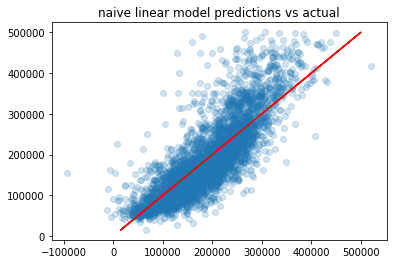

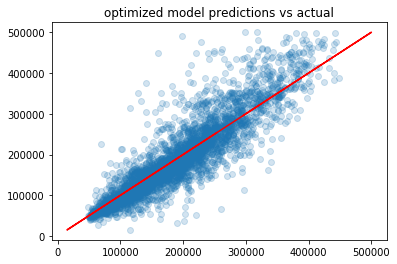

In [18]:
# 15. compare predicted vs actual response values to gauge model performance

rf_predict = trained_model.predict(X_test_xform)
lm_predict = linear_model.predict(X_test_xform)

plt.scatter(x = lm_predict, y = y_test, alpha=0.2)
plt.plot(y_test, y_test, c="red")
plt.title("naive linear model predictions vs actual")
plt.show()

plt.scatter(x = rf_predict, y = y_test, alpha=0.2)
plt.plot(y_test ,y_test, c="red")
plt.title("optimized model predictions vs actual")
plt.show()

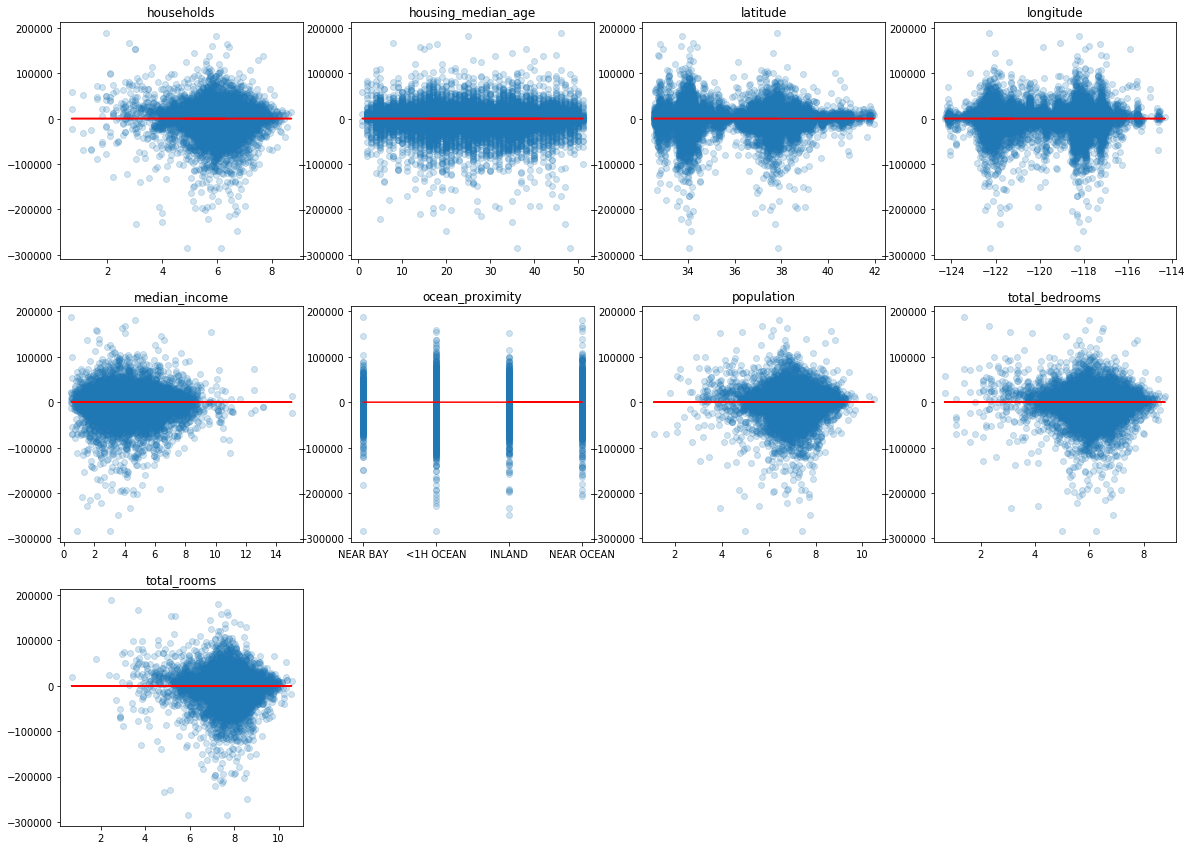

In [19]:
# 16. plot optimal model residuals versus predictor variables and look for trends

def get_model_res(X, y_predict, y_actual, nrow=4, ncol=4):
    resid = y_predict - y_actual
    fig   = plt.figure(figsize=(20,20))
    cols  = list(X)
    for i, col in enumerate(cols):
        axis = fig.add_subplot(nrow, ncol, i+1)
        plt.scatter(x=X[col], y=resid, alpha=0.2)
        plt.plot(X[col], np.repeat(0, len(X[col])), c="red")
        axis.set_title(col)
    plt.show()
        
X_xform   = xform_pipeline.fit_transform(X)
y_predict = optimal_model.predict(X_xform)
get_model_res(X, y_predict, y)

### Summary of Results

Model selection found an optimal combination of model and hyperparamters, among those considered, to estimate the response variable from the available data. The final random forest model is an improvement over an overfit linear model, showing that the model testing strategy is already showing an improvement. Analysis of the residual plots may provide clues for how further feature engineering could improve over the current model.

In gneeral, model performance could be improved in a variety of ways. Further hyperparameter tuning and additional considered models, such as gradient boosted modeling, could have the potential to improve performance significantly by leveraging computer time as opposed to programmer time. However, so far no feature engineering has been done. Bringing in external data sources or finding creative ways to transform currently available data could also improve model performance dramatically. Either way offers potential next steps for improving upon this model.